In [2]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception


In [3]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1' # This will allow automatic expression to take place.

In [16]:
#  Specify root path
root_path =r'C:\Users\hp388\project working\Raw Dataset/'

# Get class names
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Calculate class distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

Number of Classes : 12
Class names : ['American Shorthair', 'Bengal', 'Bombay', 'Domestic Long Hair', 'Egyptian Mau', 'Extra-Toes Cat - Hemingway Polydactyl', 'Himalayan', 'Manx', 'Persian', 'Russian Blue', 'Turkish Angora', 'Tuxedo']


In [17]:
# Pie plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [18]:
# Bar Plot
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [19]:
# Initialize generator
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.2
)

In [20]:
# Load Data
train_ds = gen.flow_from_directory(
    root_path,
    batch_size=128, # For better utilization of GPU, I have kept the batch size a little bit
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='training'
)

valid_ds = gen.flow_from_directory(
    root_path,
    batch_size=64, # For faster inference, the batch size here is small.
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='validation'
)

Found 2947 images belonging to 12 classes.
Found 731 images belonging to 12 classes.


In [21]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):
    
    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)
    
    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size
    
    # Iterate through the subplots.
    for i in range(1, n_images+1):
        
        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]
        
        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"
        
        plt.title(title)
    plt.show()

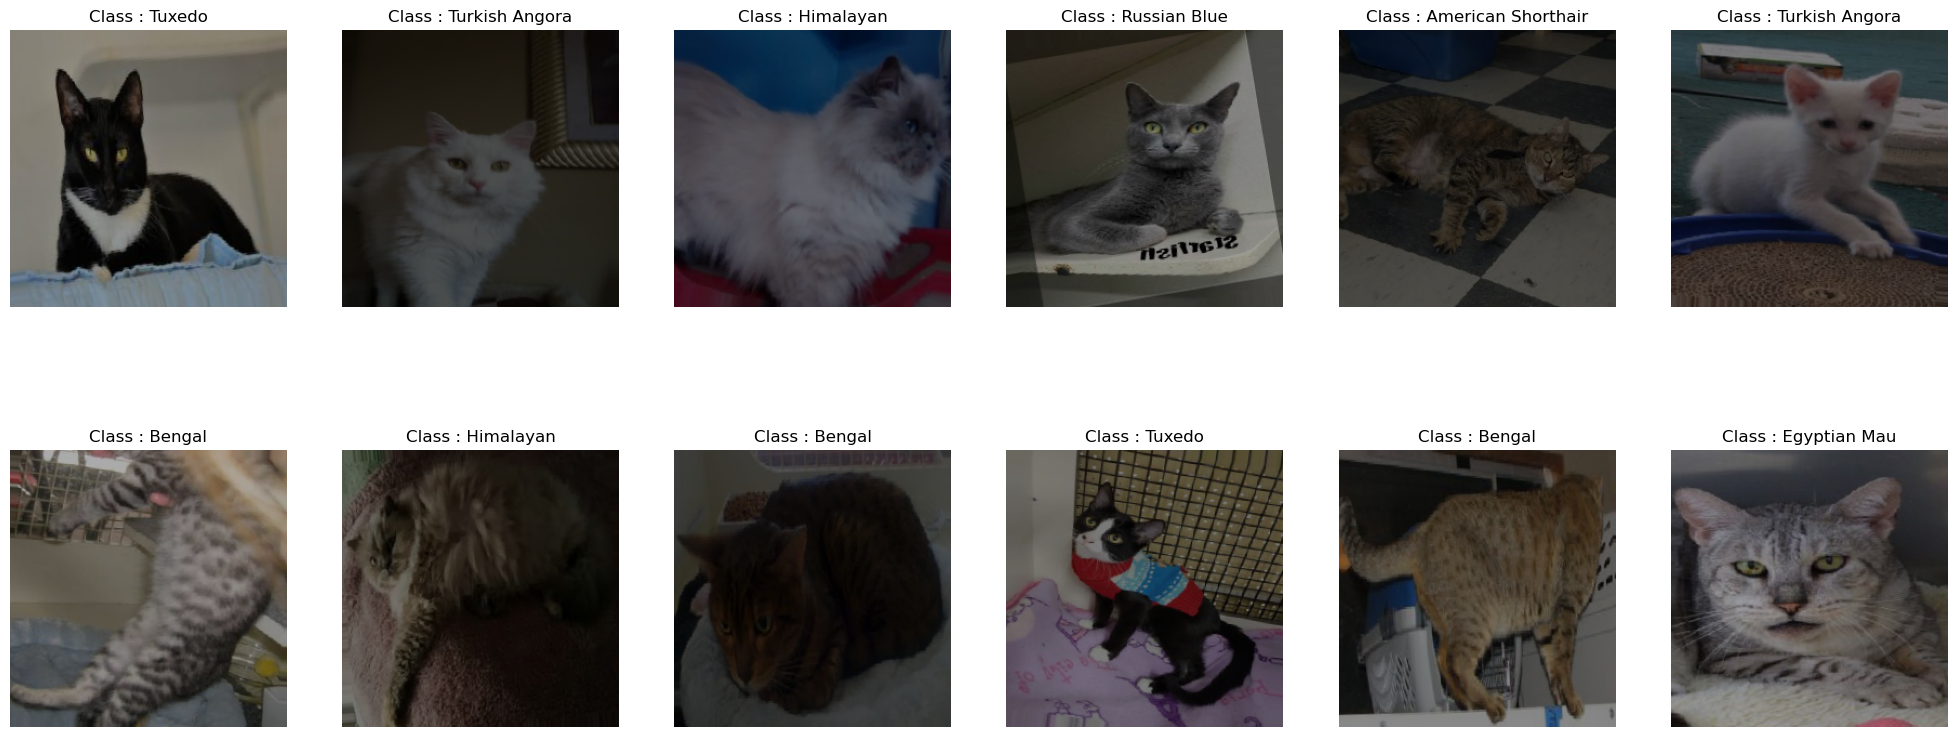

In [22]:
show_images(data=train_ds)

In [23]:
# Give you a model, a name
name = "inception-v3"

# Base model
base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

# Callbacks
cbs = [ES(patience=3, restore_best_weights=True), MC(name + ".h5", save_best_only=True)]

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # Higher than the default learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=cbs)


87910968/87910968 [==============================] - 39s 0us/step
Epoch 1/50
24/24 [==============================] - 1204s 50s/step - loss: 2.0232 - accuracy: 0.3176 - val_loss: 1.6879 - val_accuracy: 0.4309
Epoch 2/50
24/24 [==============================] - 1198s 50s/step - loss: 1.6052 - accuracy: 0.4550 - val_loss: 1.5856 - val_accuracy: 0.4843
Epoch 3/50
24/24 [==============================] - 1046s 43s/step - loss: 1.5026 - accuracy: 0.4975 - val_loss: 1.6606 - val_accuracy: 0.4268
Epoch 4/50
24/24 [==============================] - 892s 37s/step - loss: 1.4592 - accuracy: 0.5036 - val_loss: 1.5934 - val_accuracy: 0.4583
Epoch 5/50
24/24 [==============================] - 873s 36s/step - loss: 1.4392 - accuracy: 0.5148 - val_loss: 1.4924 - val_accuracy: 0.5103
Epoch 6/50
24/24 [==============================] - 866s 36s/step - loss: 1.3661 - accuracy: 0.5375 - val_loss: 1.5512 - val_accuracy: 0.4733
Epoch 7/50
24/24 [==============================] - 864s 36s/step - loss: 1.358

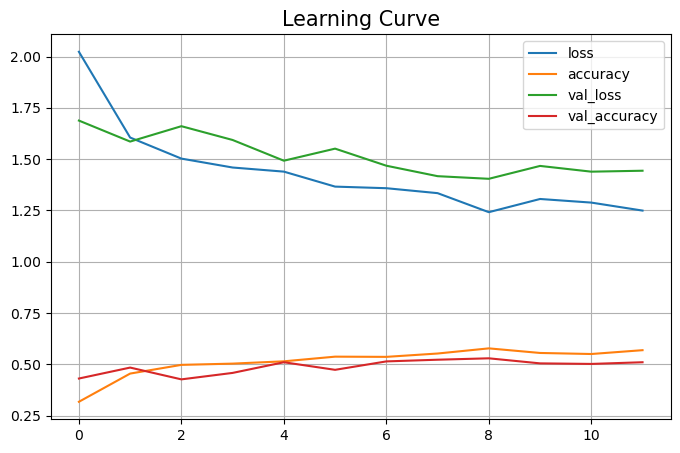

1/1 [==============================] - 0s 284ms/step


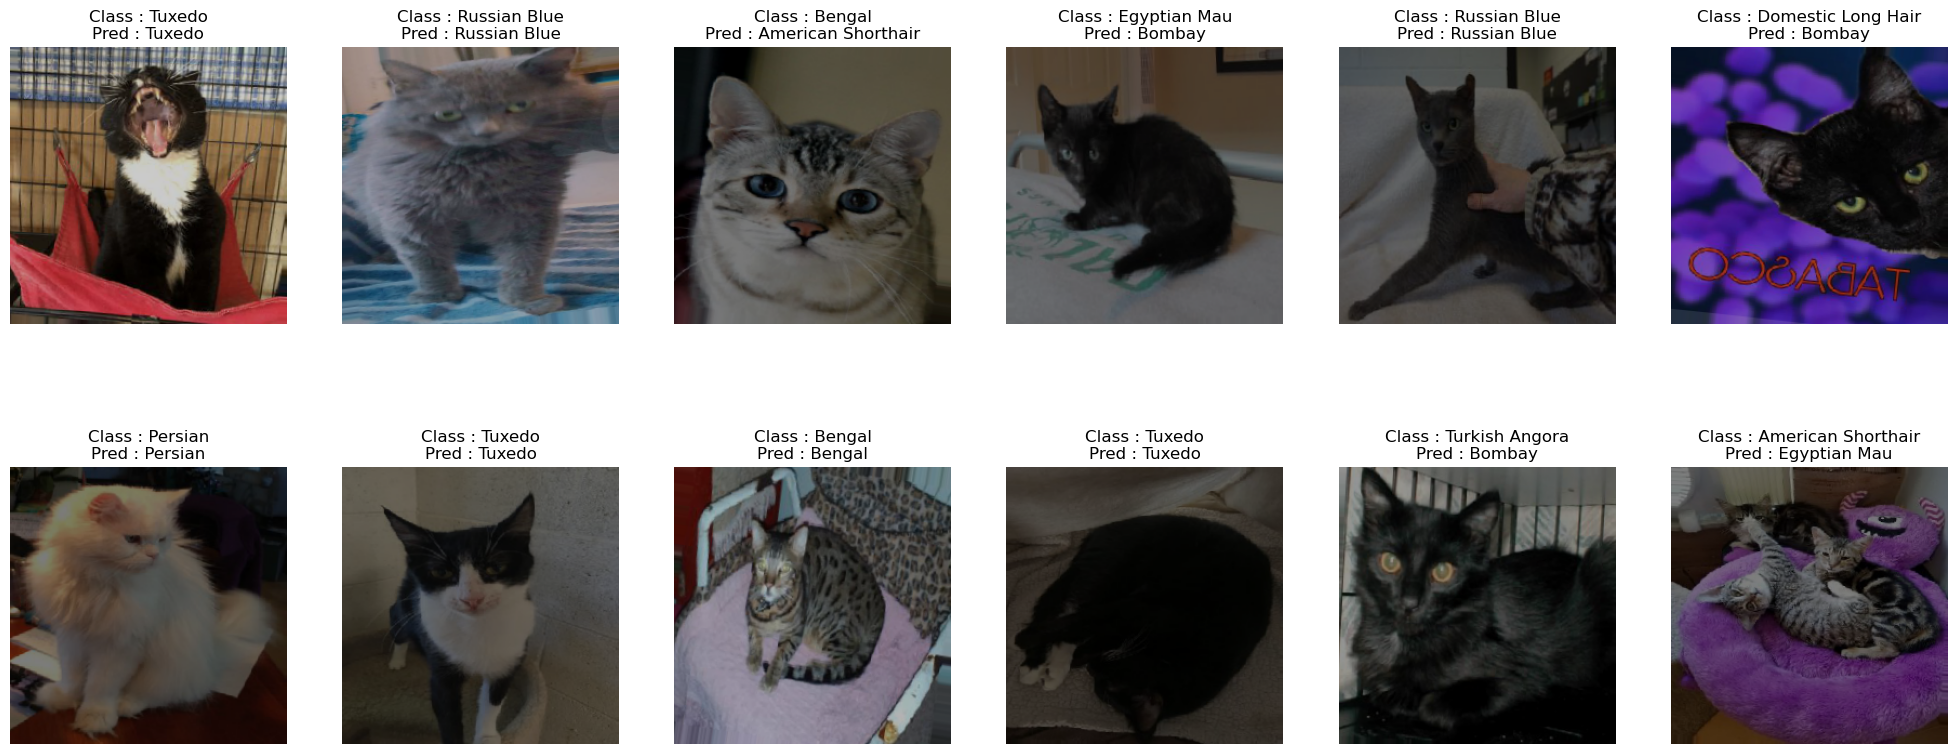

In [41]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.show()
show_images(data=valid_ds, model=model)